<a href="https://colab.research.google.com/github/StephenJohnson-CardiffUni/Astro/blob/main/GalaxiesAssignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
from scipy.integrate import quad
import matplotlib.pyplot as plt



In [2]:
initialMass = 1e11
print(initialMass)

100000000000.0


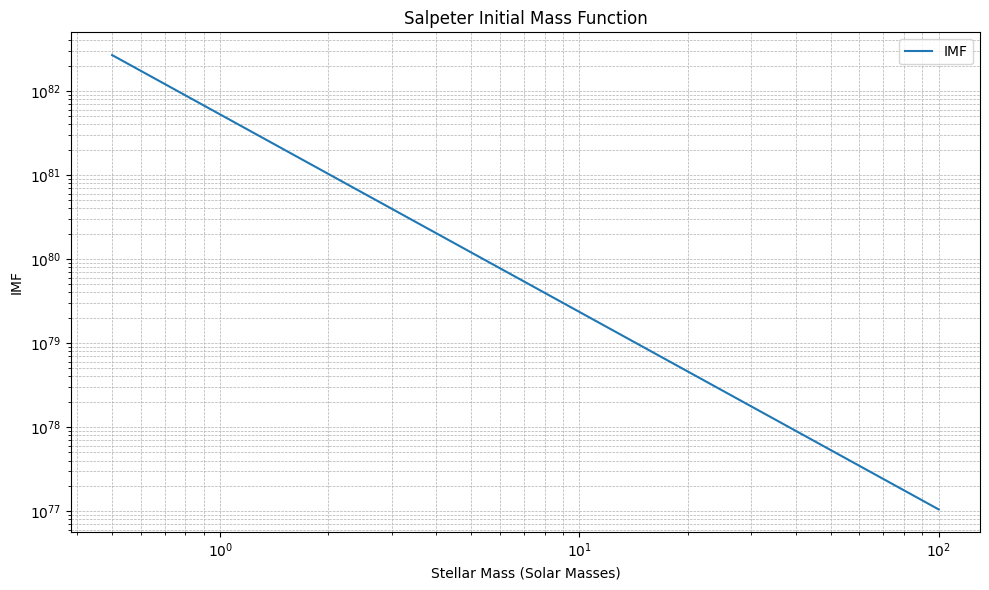

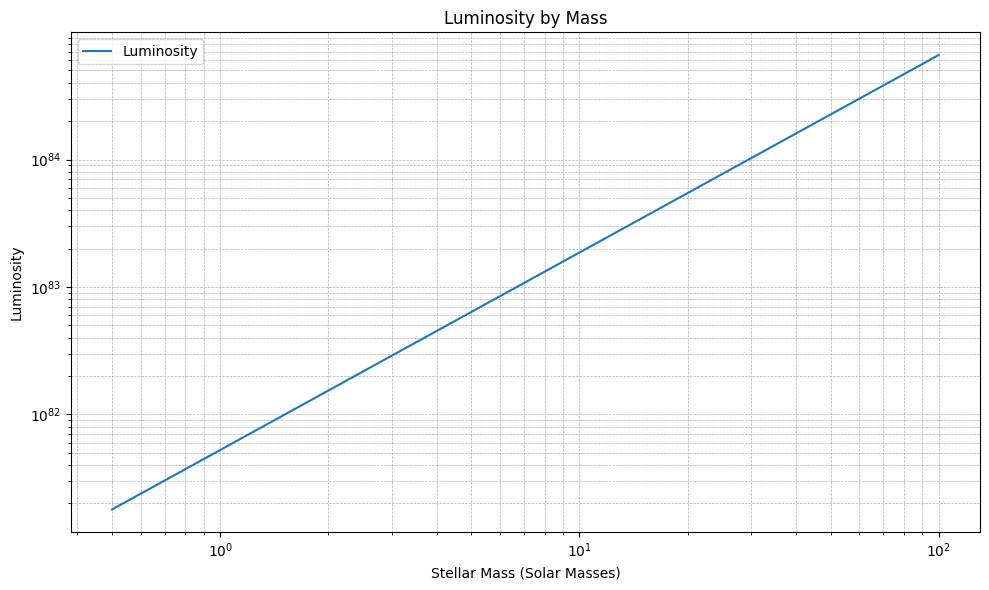

In [3]:
#Constants
SolarLumin = 3.828e26  # Solar luminosity in watts
SolarM = 2e30  # Solar mass in kilograms
Salpeter = 2.35
initialMass = 1e11 #Mass of Cloud in SolarMasses
galaxyLifetime = 12e9 #LifeTime in Years

# Assuming a lower limit of 0.5 solar masses and an upper limit of some solar masses
StarMassMin = 0.5
StarMassMax = 100

#Star Formation Rate
SFR = initialMass / 1e9


def luminosity_func(M): #Takes mass in SolarM, returns in solar luminosities
  return (M)**3.9

def lifeTime_func(M): #Take Mass in SolarM, returns lifetime on main sequence
  return 1e9 * (M)**-2.5

def Mcrit(t): #Takes time in years, returns mass of stars whos life time is equal to this (the ones just dying in a galaxy t old)
  return ((10e9/t)**1/2.5)

def IMFconst(MassTot):#function to find the IMF constant
  return MassTot / (quad(IMFintegrand,StarMassMin,StarMassMax)[0])

def IMFintegrand(m):#needed for the constant
  return m**-1.35

def IMF(M):#Gives distribution of masses from a cloud of certain size
  return IMFconst(initialMass) * (M/SolarM)**-Salpeter

masses = np.linspace(StarMassMin, StarMassMax, num=1000) #TestMasses for Graphing

IMFvals = IMF(masses) # Mass Dristribution

lumsByMass = IMFvals*luminosity_func(masses) # IMF*luminositys | In Solar Lumins


#Plot the Initial Mass Function and lumins By mass for sanity check

plt.figure(figsize=(10, 6))
plt.plot(masses, IMFvals, label='IMF')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Stellar Mass (Solar Masses)')
plt.ylabel('IMF')
plt.title('Salpeter Initial Mass Function')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()


plt.figure(figsize=(10, 6))
plt.plot(masses, lumsByMass, label='Luminosity')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Stellar Mass (Solar Masses)')
plt.ylabel('Luminosity')
plt.title('Luminosity by Mass')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

totalLumin = sum(lumsByMass)

In [4]:
print(totalLumin)

2.605069145017857e+87


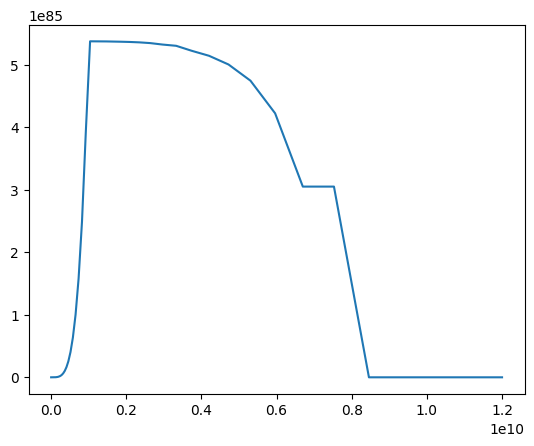

In [5]:
steps = 200
SFR = initialMass / 1e9

timeArray = np.geomspace(1,12e9,num=steps)
TimeStepLuminosity = np.zeros(steps)
Nm = np.zeros((steps, len(masses)))
massByMass = np.zeros((steps, len(masses)))

for i, t in enumerate(timeArray):#at every time step we clear the Number count arrays
    NmLow = np.zeros_like(masses)
    NmHigh = np.zeros_like(masses)
    if t < 1e9: #if under 1billion, star formation is still ongoing
      for j, m in enumerate(masses):
        if m < Mcrit(t):
            NmLow[j] = IMFconst(initialMass) * SFR * t * m**-2.35
        elif m > Mcrit(t):
            NmHigh[j] = IMFconst(initialMass) * SFR * 10e9 * m**-4.85  # 10e9 = Solar Lifetime
    else:
      for j, m in enumerate(masses):
        if m < Mcrit(t):
            NmLow[j] = IMFconst(initialMass) * SFR * 1e9 * m**-2.35 #1e9 = end of star formation
        elif m > Mcrit(t):
            NmHigh[j] = 0
    Nm[i] = NmLow + NmHigh
    massByMass[i] = Nm[i] * masses
    TimeStepLuminosity[i] = np.sum(luminosity_func(massByMass[i]))

plt.plot(timeArray, TimeStepLuminosity)
# plt.xscale('log')
# plt.yscale('log')


In [11]:
print(massByMass[len(massByMass)-1])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

In [6]:
Lows = np.array([1,2,3,0,0,0])
Highs = np.array([0,0,0,4,5,6])
Run = Lows + Highs
print(Run)

[1 2 3 4 5 6]


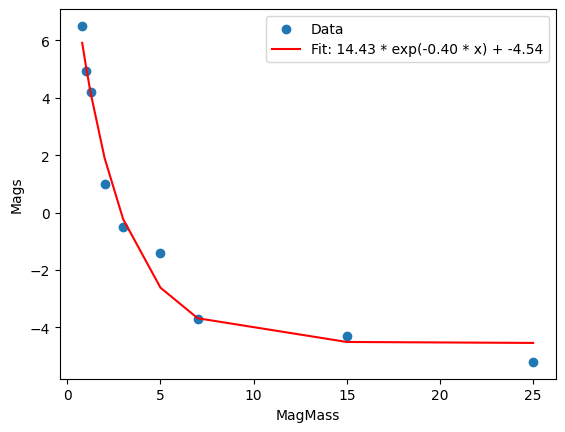

In [7]:
from scipy.optimize import curve_fit

# Data
MagMass = np.array([0.8, 1.0, 1.25, 2, 3, 5, 7, 15, 25])
Mags = np.array([6.5, 4.93, 4.2, 1.0, -0.5, -1.4, -3.7, -4.3, -5.2])

# Define modified exponential decay model function with offset
def exp_decay(x, a, b, offset):
    return a * np.exp(-b * x) + offset

# Perform curve fitting
popt, pcov = curve_fit(exp_decay, MagMass, Mags)

# Get fitted parameters
a_fit, b_fit, offset_fit = popt

# Plot data and fitted curve
plt.scatter(MagMass, Mags, label='Data')
plt.plot(MagMass, exp_decay(MagMass, a_fit, b_fit, offset_fit), color='red', label='Fit: {:.2f} * exp(-{:.2f} * x) + {:.2f}'.format(a_fit, b_fit, offset_fit))
plt.xlabel('MagMass')
plt.ylabel('Mags')
plt.legend()
plt.show()


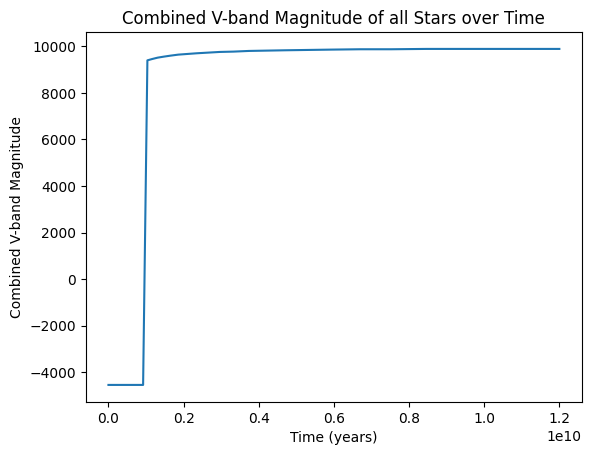

In [8]:
def mass_vmag(mass):
    return exp_decay(mass, a_fit, b_fit, offset_fit)

vmag_distribution = mass_vmag(massByMass)

combined_vmag = np.sum(vmag_distribution, axis=1)

# Plot combined V-band magnitude versus time
plt.plot(timeArray, combined_vmag)
plt.xlabel('Time (years)')
plt.ylabel('Combined V-band Magnitude')
plt.title('Combined V-band Magnitude of all Stars over Time')
plt.show()